In [13]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
 
 
from nltk import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
 
 
%matplotlib inline

Load Data from Drive

In [ ]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
 
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
 
# downloaded = drive.CreateFile({'id':"10M8EG86sQvDhWNzYnpcawnKIhQ-S9eGr"})   # replace the id with id of file you want to access
# downloaded.GetContentFile('DatasetFinal.csv')

Show some data to cehck if loaded successfuly ?

In [10]:
import pandas as pd

url = 'https://raw.githubusercontent.com/BurhanUlHaqq/ResearchWork/main/data/DatasetFinal.csv'
data = pd.read_csv(url, sep=',', header=0)
data.head()

,Sentiments,Positive
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1
2,kya bt hai,1
3,wah je wah,1
4,are wha kaya bat hai,1


Sentiments Length 

In [11]:
data['len'] = [len(t) for t in data.Sentiments]
data.head(4)

,Sentiments,Positive,len
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,1,97
1,sahi bt h,1,9
2,kya bt hai,1,10
3,wah je wah,1,10


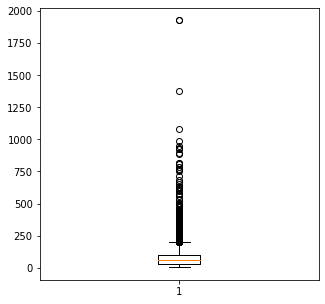

In [14]:
fig,ax = plt.subplots(figsize=(5,5))
plt.boxplot(data.len)
plt.show()

Finde the noise data (Too much length) more then 500

In [15]:
data[data.len > 500].head()

,Sentiments,Positive,len
1021,gumshoda aur agwa shoda ashkhas ki bazyabi key...,1,759
1023,insani haqooq key leyeh ansar burney ki khidma...,1,615
1027,yon to asma jahangir ki puri zindagi hi amriaa...,1,921
1230,app shaheed huye to app ki jaib se ruppey aik ...,1,893
1245,malala yousafzai ne zamana e talib e elmi mein...,1,501


Negitive Sentiments

In [16]:
neg_Sentiments = data[data.Positive == 0]
neg_words = []
for t in neg_Sentiments.Sentiments:
    neg_words.append(t)
neg_words[:4]

['asif momin hakir nahi fakir hai mera sabr us ny sameta hai',
 'phely jaa kr naha ky ao phr mazi ko khechna',
 'ye to bilkul thk kaha aur hamra km hi dushmano ko jalana h',
 'dukh hi dukh zindhge mein']

In [17]:
neg_text = pd.Series(neg_words).str.cat(sep=' ')
neg_text[:110]

'asif momin hakir nahi fakir hai mera sabr us ny sameta hai phely jaa kr naha ky ao phr mazi ko khechna ye to b'

In [18]:
for t in neg_Sentiments.Sentiments[:100]:
    if 'good' in t:
        print(t)

good news kanjr mar gai


Positive Sentenses

In [19]:
pos_sentiments = data[data.Positive == 1] ## 1 is positive sentiment
pos_string = []
for t in pos_sentiments.Sentiments:
    pos_string.append(t)
pos_text = pd.Series(pos_string).str.cat(sep=' ')
pos_text[:110]

'sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi aj aur aj bi sirf aus say bus sahi bt h ky'

Word Cloud for negatively classified movie reviews

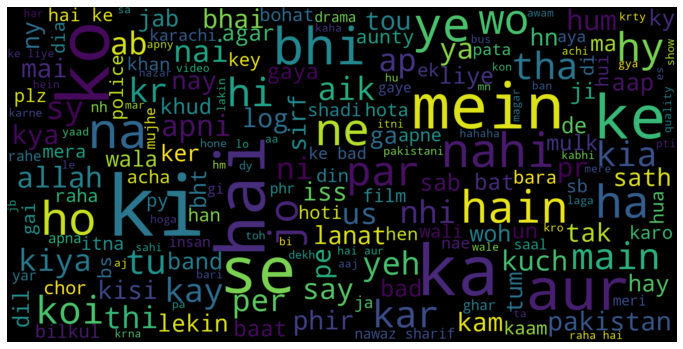

In [20]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for positively classified movie reviews

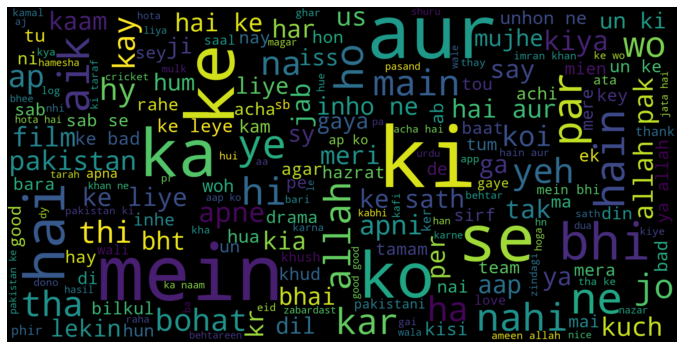

In [21]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

CountVectorizer to calculate term frequencies

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
cvector = CountVectorizer(min_df = 0.0, max_df = 1.0, ngram_range=(1,2))
cvector.fit(data.Sentiments)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [23]:
len(cvector.get_feature_names())

135576

In [24]:
neg_matrix = cvector.transform(data[data.Positive == 0].Sentiments)
pos_matrix = cvector.transform(data[data.Positive == 1].Sentiments)

Term Frequency for 'Negitive' sentiments

In [49]:
neg_words = neg_matrix.sum(axis=0)
neg_words_freq = [(word, neg_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','negative'])
neg_tf.head(5)

,Terms,negative
0,ki,1621
1,hai,1241
2,ko,1211
3,ke,1101
4,ka,1097


Just updating the Headings

In [26]:
neg_tf_df = neg_tf.set_index('Terms')
neg_tf_df.head()

,negative
Terms,
ki,1621
hai,1241
ko,1211
ke,1101
ka,1097


Term Frequency for 'positive' sentiments

In [54]:
pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word, pos_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
pos_words_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','positive'])
pos_words_tf_df = pos_words_tf.set_index('Terms')
pos_words_tf_df.head()

,positive
Terms,
ki,2460
ke,2449
mein,1858
hai,1537
aur,1522


idf

In [28]:
term_freq_df = pd.concat([neg_tf_df,pos_words_tf_df],axis=1)

Total Term Frequency of both sentiment classes

In [29]:
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive'] 
term_freq_df.sort_values(by='total', ascending=False).head(20)

,negative,positive,total
ki,1621,2460,4081
ke,1101,2449,3550
hai,1241,1537,2778
mein,854,1858,2712
ko,1211,1353,2564
ka,1097,1366,2463
aur,719,1522,2241
se,917,1285,2202
ne,490,904,1394
bhi,498,699,1197


 Frequency plot of top frequent 500 Sentiments

Text(0.5, 1.0, 'Top 500 Sentiments')

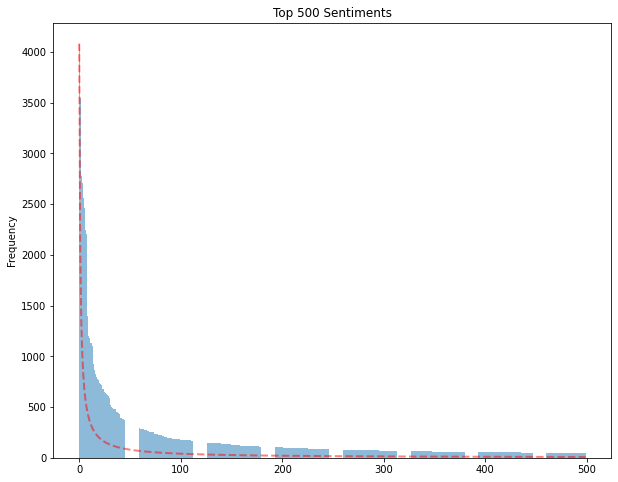

In [30]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 Sentiments')

 Plot of Absolute frequency of Sentiments against their rank

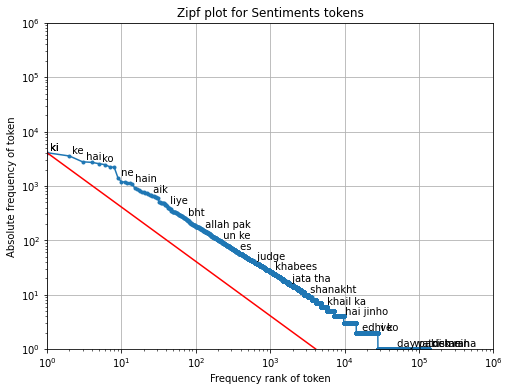

In [31]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for Sentiments tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [79]:
neg_bag=neg_text.split(' ')
print(neg_bag)

['asif', 'momin', 'hakir', 'nahi', 'fakir', 'hai', 'mera', 'sabr', 'us', 'ny', 'sameta', 'hai', 'phely', 'jaa', 'kr', 'naha', 'ky', 'ao', 'phr', 'mazi', 'ko', 'khechna', 'ye', 'to', 'bilkul', 'thk', 'kaha', 'aur', 'hamra', 'km', 'hi', 'dushmano', 'ko', 'jalana', 'h', 'dukh', 'hi', 'dukh', 'zindhge', 'mein', 'or', 'ya', 'assa', 'he', 'hotta', 'hajassya', 'khamosh', 'samander', 'key', 'lahryain', 'jb', 'utthyee', 'hain', 'to', 'pir', 'sub', 'kuch', 'bahaa', 'kr', 'lya', 'jathyee', 'hainso', 'be', 'care', 'full', 'twadi', 'bahan', 'noo', 'ln', 'waday', 'police', 'waliyaan', 'dee', 'noo', 'yaar', 'dil', 'kar', 'raha', 'hai', 'sab', 'police', 'station', 'ko', 'bomb', 'say', 'uraa', 'dey', 'banda', 'laanat', 'hai', 'aisay', 'qanoon', 'per', 'jo', 'logoon', 'ko', 'tuhafaz', 'deinay', 'ki', 'bajhaye', 'inhein', 'hi', 'zaleel', 'karay', 'aur', 'laanat', 'hai', 'aisay', 'qanoon', 'bananay', 'waloon', 'per', 'bhi', 'jinhoon', 'nay', 'apnay', 'jaisay', 'begairat', 'corrupt', 'loag', 'barti', 'kiye

In [80]:
pos_bag=pos_text.split(' ')
print(pos_bag)

['sai', 'kha', 'ya', 'her', 'kisi', 'kay', 'bus', 'ki', 'bat', 'nhi', 'hai', 'lakin', 'main', 'ki', 'hal', 'kal', 'bi', 'aj', 'aur', 'aj', 'bi', 'sirf', 'aus', 'say', 'bus', 'sahi', 'bt', 'h', 'kya', 'bt', 'hai', 'wah', 'je', 'wah', 'are', 'wha', 'kaya', 'bat', 'hai', 'wah', 'kya', 'baat', 'likhi', 'wha', 'itni', 'sari', 'khubiya', 'itni', 'khubiya', 'ya', 'allah', 'rehm', 'farma', 'hm', 'sab', 'pe', 'or', 'zalimo', 'ko', 'hidayat', 'de', 'ameen', 'please', 'everyone', 'allah', 'swt', 'ka', 'naam', 'hamesha', 'bary', 'lawzo', 'main', 'likha', 'kary', 'wo', 'he', 'zaat', 'sub', 'say', 'bari', 'hey', 'ya', 'mere', 'rab', 'tu', 'bra', 'kreem', 'hy', 'is', 'mulk', 'k', 'halat', 'pr', 'reham', 'frma', 'is', 'watneaziz', 'ki', 'hifazat', 'frmaamin', 'jaago', 'pakistani', 'coom', 'jaago', 'ye', 'humary', 'nokar', 'han', 'humarey', 'tex', 'se', 'inko', 'tankha', 'milti', 'h', 'or', 'ye', 'hum', 'pakitani', 'awam', 'ko', 'hi', 'martey', 'han', 'jaago', 'pakistan', 'key', 'logo', 'kia', 'kia', '

In [81]:

uniqueWords = set(neg_bag).union(set(pos_bag))
print(uniqueWords)

{'lashari', 'pehchaaan', 'khilariyon', 'ae', 'randy', 'zaada', 'talkeen', 'zari', 'besharam', 'qeemat', 'abadat', 'lagtay', 'shoda', 'qasmy', 'cmbalochistan', 'sparing', 'gungunana', 'muballigheen', 'marey', 'option', 'robina', 'howi', 'bhaagne', 'sial', 'adi', 'talba', 'hoay', 'coverge', 'hoein', 'jatey', 'dolll', 'tukay', 'ibteda', 'pathon', 'struggle', 'belts', 'atah', 'hafta', 'machata', 'achche', 'ahalkar', 'tapne', 'feels', 'azmat', 'pehnna', 'dirty', 'selab', 'mutaliq', 'mehbub', 'neendain', 'merry', 'iey', 'markazi', 'kot', 'pasay', 'ranaa', 'pochti', 'nazarr', 'taziyat', 'zaid', 'sathiyon', 'adyan', 'productions', 'phopiu', 'mangne', 'jeettey', 'drama', 'sulah', 'fankarana', 'karnama', 'chutti', 'dubara', 'ratin', 'world', 'rbb', 'royal', 'bna', 'banti', 'cool', 'sajdey', 'baqaiyda', 'hallah', 'charcoal', 'huee', 'gayb', 'zarirat', 'nu', 'banne', 'mustakil', 'theateron', 'saport', 'ammen', 'stand', 'naslein', 'rupya', 'tiet', 'neyie', 'uta', 'humen', 'rakhaen', 'sahleh', 'zanz

In [83]:
numOfWordsN = dict.fromkeys(uniqueWords, 0)
for word in neg_bag:
    numOfWordsN[word] += 1

numOfWordsP = dict.fromkeys(uniqueWords, 0)
for word in pos_bag:
    numOfWordsP[word] += 1

In [84]:
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

In [85]:
tf_N = computeTF(numOfWordsN, neg_bag)
tf_P = computeTF(numOfWordsP, pos_bag)

In [86]:
print(tf_P)

{'lashari': 0.0, 'pehchaaan': 0.0, 'khilariyon': 0.00012552826478095318, 'ae': 0.00010460688731746098, 'randy': 0.0, 'zaada': 1.0460688731746098e-05, 'talkeen': 0.0, 'zari': 1.0460688731746098e-05, 'besharam': 0.0, 'qeemat': 0.00013598895351269927, 'abadat': 2.0921377463492197e-05, 'lagtay': 2.0921377463492197e-05, 'shoda': 1.0460688731746098e-05, 'qasmy': 0.0, 'cmbalochistan': 0.0, 'sparing': 1.0460688731746098e-05, 'gungunana': 1.0460688731746098e-05, 'muballigheen': 1.0460688731746098e-05, 'marey': 0.0, 'option': 1.0460688731746098e-05, 'robina': 1.0460688731746098e-05, 'howi': 0.0, 'bhaagne': 1.0460688731746098e-05, 'sial': 1.0460688731746098e-05, 'adi': 1.0460688731746098e-05, 'talba': 6.276413239047659e-05, 'hoay': 0.0, 'coverge': 1.0460688731746098e-05, 'hoein': 7.322482112222268e-05, 'jatey': 3.1382066195238295e-05, 'dolll': 1.0460688731746098e-05, 'tukay': 0.0, 'ibteda': 6.276413239047659e-05, 'pathon': 1.0460688731746098e-05, 'struggle': 1.0460688731746098e-05, 'belts': 2.092

In [87]:
def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

In [88]:
print(numOfWordsP)
idfs = computeIDF([numOfWordsN, numOfWordsP])
# print(idfs)

{'lashari': 0, 'pehchaaan': 0, 'khilariyon': 12, 'ae': 10, 'randy': 0, 'zaada': 1, 'talkeen': 0, 'zari': 1, 'besharam': 0, 'qeemat': 13, 'abadat': 2, 'lagtay': 2, 'shoda': 1, 'qasmy': 0, 'cmbalochistan': 0, 'sparing': 1, 'gungunana': 1, 'muballigheen': 1, 'marey': 0, 'option': 1, 'robina': 1, 'howi': 0, 'bhaagne': 1, 'sial': 1, 'adi': 1, 'talba': 6, 'hoay': 0, 'coverge': 1, 'hoein': 7, 'jatey': 3, 'dolll': 1, 'tukay': 0, 'ibteda': 6, 'pathon': 1, 'struggle': 1, 'belts': 2, 'atah': 1, 'hafta': 1, 'machata': 0, 'achche': 2, 'ahalkar': 2, 'tapne': 0, 'feels': 0, 'azmat': 11, 'pehnna': 2, 'dirty': 0, 'selab': 3, 'mutaliq': 2, 'mehbub': 2, 'neendain': 1, 'merry': 1, 'iey': 1, 'markazi': 12, 'kot': 3, 'pasay': 0, 'ranaa': 1, 'pochti': 1, 'nazarr': 1, 'taziyat': 0, 'zaid': 7, 'sathiyon': 4, 'adyan': 1, 'productions': 2, 'phopiu': 0, 'mangne': 4, 'jeettey': 1, 'drama': 74, 'sulah': 1, 'fankarana': 3, 'karnama': 7, 'chutti': 2, 'dubara': 1, 'ratin': 0, 'world': 40, 'rbb': 0, 'royal': 6, 'bna': 

In [89]:
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [90]:
tfidfN = computeTFIDF(tf_N, idfs)
tfidfP = computeTFIDF(tf_P, idfs)

df = pd.DataFrame([tfidfN, tfidfP])